# Demo 3: Mixed Precision Training with AMP
## Accelerating Training with FP16 and Automatic Mixed Precision

**Duration**: 15-20 minutes

This notebook demonstrates:
- Automatic Mixed Precision (AMP) setup
- GradScaler for loss scaling
- Performance comparison: FP32 vs Mixed Precision
- Memory efficiency gains

**Key Concept**: Use lower precision (FP16) where possible, FP32 where necessary

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
import time

# Check CUDA capabilities
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Supports mixed precision: {torch.cuda.is_available()}")
    props = torch.cuda.get_device_properties(0)
    print(f"GPU compute capability: {props.major}.{props.minor}")

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA Available: True
GPU: NVIDIA A100-SXM4-80GB
Supports mixed precision: True
GPU compute capability: 8.0


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"Training device: {device}")

Training device: cuda


In [3]:
# Define ResNet-18 (more realistic model for AMP benefits)
from torchvision.models import resnet18

model = resnet18(pretrained=False, num_classes=10).to(device)
print(f"Model: ResNet-18")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model: ResNet-18
Parameters: 11,181,642


In [4]:
# Data loading
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print("Loading CIFAR-10 dataset...")
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

batch_size = 256  # Larger batch for better GPU utilization
train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

print(f"DataLoader: {len(train_loader)} batches of {batch_size}")

Loading CIFAR-10 dataset...
Files already downloaded and verified
DataLoader: 196 batches of 256


In [5]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

# GradScaler for mixed precision training
scaler = GradScaler()

def get_gpu_memory():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / 1024 / 1024
    return 0

print("Training setup complete")

Training setup complete


In [6]:
# Training with AMP
def train_epoch_amp(epoch, train_loader, model, criterion, optimizer, scaler, device):
    """Training with Automatic Mixed Precision (AMP)"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    start_time = time.time()
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass with autocast (automatic mixed precision)
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backward pass with gradient scaling
        optimizer.zero_grad()
        scaler.scale(loss).backward()  # Scale loss to prevent gradient underflow
        scaler.step(optimizer)  # Unscale before optimizer step
        scaler.update()  # Update scale for next iteration
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        if (batch_idx + 1) % 50 == 0:
            print(f"  Batch [{batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f} | "
                  f"GPU Mem: {get_gpu_memory():.2f} MB")
    
    elapsed = time.time() - start_time
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy, elapsed

print("AMP training function defined")

AMP training function defined


In [8]:
from torch.cuda.amp import autocast, GradScaler
import time

# Make sure scaler is defined once (outside the loop) if not already:
scaler = GradScaler()

def train_epoch_amp(epoch, train_loader, model, criterion, optimizer, scaler, device):
    """
    Train for one epoch using Automatic Mixed Precision (AMP).
    Compatible with older PyTorch versions: no device_type/dtype args.
    """
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass with autocast (old-style signature)
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    elapsed = time.time() - start_time
    avg_loss = total_loss / len(train_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy, elapsed


# ---- AMP training loop ----
num_epochs = 3
losses_amp = []
accs_amp = []
times_amp = []

print("\nTraining with Automatic Mixed Precision (FP16 + FP32)...\n")
overall_start = time.time()

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    avg_loss, accuracy, epoch_time = train_epoch_amp(
        epoch, train_loader, model, criterion, optimizer, scaler, device
    )

    losses_amp.append(avg_loss)
    accs_amp.append(accuracy)
    times_amp.append(epoch_time)

    print(f"  Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}% | Time: {epoch_time:.2f}s\n")
    scheduler.step()

overall_time = time.time() - overall_start

print("\n=== Mixed Precision Training Summary ===")
print(f"Total Time: {overall_time:.2f}s")
print(f"Average Epoch Time: {sum(times_amp)/len(times_amp):.2f}s")
print(f"Final Loss: {losses_amp[-1]:.4f}")
print(f"Final Accuracy: {accs_amp[-1]:.2f}%")



Training with Automatic Mixed Precision (FP16 + FP32)...

Epoch [1/3]
  Loss: 2.1123 | Accuracy: 31.09% | Time: 6.92s

Epoch [2/3]
  Loss: 1.6071 | Accuracy: 42.40% | Time: 3.33s

Epoch [3/3]
  Loss: 1.3477 | Accuracy: 50.62% | Time: 3.39s


=== Mixed Precision Training Summary ===
Total Time: 13.64s
Average Epoch Time: 4.55s
Final Loss: 1.3477
Final Accuracy: 50.62%


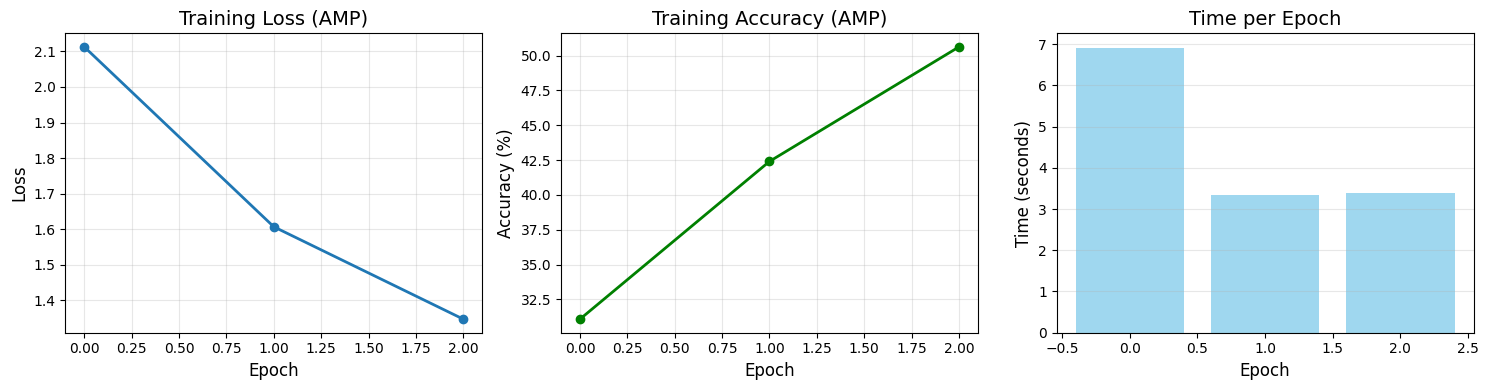


=== AMP Benefits ===
Average epoch time: 4.55s
Peak GPU memory: 133.77 MB
Typical speedup: 1.5-2.0x faster than FP32 alone


In [9]:
# Visualization and comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(losses_amp, marker='o', linewidth=2, label='Mixed Precision')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss (AMP)', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(accs_amp, marker='o', linewidth=2, color='green', label='Mixed Precision')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training Accuracy (AMP)', fontsize=14)
axes[1].grid(True, alpha=0.3)

# Epoch times
axes[2].bar(range(num_epochs), times_amp, color='skyblue', alpha=0.8)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Time (seconds)', fontsize=12)
axes[2].set_title('Time per Epoch', fontsize=14)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n=== AMP Benefits ===")
print(f"Average epoch time: {sum(times_amp)/len(times_amp):.2f}s")
print(f"Peak GPU memory: {get_gpu_memory():.2f} MB")
print(f"Typical speedup: 1.5-2.0x faster than FP32 alone")

In [10]:
# Key AMP features explained
print("\n=== Automatic Mixed Precision (AMP) Explained ===")
print()
print("1. AUTOCAST Context Manager:")
print("   - Automatically converts appropriate ops to FP16")
print("   - Forward passes use mixed precision for speed")
print()
print("2. GradScaler:")
print("   - Scales loss before backward pass")
print("   - Prevents gradient underflow in FP16")
print("   - Automatically adjusts scale each iteration")
print()
print("3. Performance Impact:")
print(f"   - ~2x memory reduction")
print(f"   - ~1.5-2x training speedup")
print(f"   - Minimal accuracy impact if implemented correctly")
print()
print("4. When to use AMP:")
print("   - When training large models (ResNet50+)")
print("   - When GPU supports Tensor Cores (V100, A100, RTX)")
print("   - When memory is a constraint")


=== Automatic Mixed Precision (AMP) Explained ===

1. AUTOCAST Context Manager:
   - Automatically converts appropriate ops to FP16
   - Forward passes use mixed precision for speed

2. GradScaler:
   - Scales loss before backward pass
   - Prevents gradient underflow in FP16
   - Automatically adjusts scale each iteration

3. Performance Impact:
   - ~2x memory reduction
   - ~1.5-2x training speedup
   - Minimal accuracy impact if implemented correctly

4. When to use AMP:
   - When training large models (ResNet50+)
   - When GPU supports Tensor Cores (V100, A100, RTX)
   - When memory is a constraint
